<a href="https://colab.research.google.com/github/musicjae/recommender-system/blob/main/NCF/original_NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Import

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge
from keras.utils import plot_model
from IPython.display import SVG
import matplotlib.pyplot as plt
from keras.backend import reshape as Reshape


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1 Data Load

In [6]:
dataset = pd.read_csv('/content/drive/My Drive/datasets/Movie_Dataset/ratings_small.csv', header=0)

In [7]:
dataset.head(1)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144


# 2 Preprocessing

### user

In [8]:
user_id = dataset['userId'].unique().tolist() # ndarray -> list
print(len(user_id))
print(type(dataset))
print(type(dataset['userId'].unique()))

671
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [9]:
user_id[:5]

[1, 2, 3, 4, 5]

In [10]:
user2i = {u:i for i,u in enumerate(user_id)}
i2user = {i:u for i,u in enumerate(user_id)}

In [11]:
user2i.items() # 예: 아이디 1 -> idx=0 부여

dict_items([(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36), (38, 37), (39, 38), (40, 39), (41, 40), (42, 41), (43, 42), (44, 43), (45, 44), (46, 45), (47, 46), (48, 47), (49, 48), (50, 49), (51, 50), (52, 51), (53, 52), (54, 53), (55, 54), (56, 55), (57, 56), (58, 57), (59, 58), (60, 59), (61, 60), (62, 61), (63, 62), (64, 63), (65, 64), (66, 65), (67, 66), (68, 67), (69, 68), (70, 69), (71, 70), (72, 71), (73, 72), (74, 73), (75, 74), (76, 75), (77, 76), (78, 77), (79, 78), (80, 79), (81, 80), (82, 81), (83, 82), (84, 83), (85, 84), (86, 85), (87, 86), (88, 87), (89, 88), (90, 89), (91, 90), (92, 91), (93, 92), (94, 93), (95, 94), (96, 95), (97, 96), (98, 97), (99, 98), (100, 99), (101, 

In [12]:
num_users = len(user2i) # user명에서 i로 변환된것을 사용

dataset 내의 모든 user에게 id 부여

In [13]:
dataset['user'] = dataset['userId'].map(user2i) # new row 'user'
print(dataset['user'].head(2))

0    0
1    0
Name: user, dtype: int64


#### movie

In [14]:
movie_id = dataset['movieId'].unique().tolist()

In [15]:
movie_id[:5]

[31, 1029, 1061, 1129, 1172]

In [16]:
movie2i = {m:i for i,m in enumerate(movie_id)}
i2movie = {i:m for i,m in enumerate(movie_id)}

In [17]:
movie2i.items()

dict_items([(31, 0), (1029, 1), (1061, 2), (1129, 3), (1172, 4), (1263, 5), (1287, 6), (1293, 7), (1339, 8), (1343, 9), (1371, 10), (1405, 11), (1953, 12), (2105, 13), (2150, 14), (2193, 15), (2294, 16), (2455, 17), (2968, 18), (3671, 19), (10, 20), (17, 21), (39, 22), (47, 23), (50, 24), (52, 25), (62, 26), (110, 27), (144, 28), (150, 29), (153, 30), (161, 31), (165, 32), (168, 33), (185, 34), (186, 35), (208, 36), (222, 37), (223, 38), (225, 39), (235, 40), (248, 41), (253, 42), (261, 43), (265, 44), (266, 45), (272, 46), (273, 47), (292, 48), (296, 49), (300, 50), (314, 51), (317, 52), (319, 53), (339, 54), (349, 55), (350, 56), (356, 57), (357, 58), (364, 59), (367, 60), (370, 61), (371, 62), (372, 63), (377, 64), (382, 65), (405, 66), (410, 67), (454, 68), (457, 69), (468, 70), (474, 71), (480, 72), (485, 73), (497, 74), (500, 75), (508, 76), (509, 77), (515, 78), (527, 79), (537, 80), (539, 81), (550, 82), (551, 83), (552, 84), (585, 85), (586, 86), (587, 87), (588, 88), (589, 89

In [18]:
num_movies = len(i2movie) # 인덱스에서 movie로 변환된 것을 사용할 것

In [19]:
dataset['movie'] = dataset['movieId'].map(movie2i)
print(dataset['movie'].head(5))

0    0
1    1
2    2
3    3
4    4
Name: movie, dtype: int64


#### ratings

In [20]:
dataset['rating'] = dataset['rating'].values
print(dataset['rating'])

0         2.5
1         3.0
2         3.0
3         2.0
4         4.0
         ... 
99999     2.5
100000    4.0
100001    4.0
100002    2.5
100003    3.5
Name: rating, Length: 100004, dtype: float64


# 2 Train/Val set 

- X_data = 예측에 사용되는 데이터셋. user, movie를 가지고 만든다  
- y_data = X_data를 가지고 수행한 것의 정답을 확인하기 위해 사용

In [21]:
X_data = dataset[['user','movie']]

In [22]:
type(X_data)
X_data.columns

Index(['user', 'movie'], dtype='object')

In [23]:
y_data = dataset['rating']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(80003, 2)
(20001, 2)
(80003,)
(20001,)


# Modeling

## 2.0 Values in the originals

- Batch size: [128,256,512,1024]
- Learning Rate: [0.0001,0.0005,0.001,0.005]
- CF Layer: 32 -> 16 -> 8
- Emb size: 16

##### Review tesor

In [25]:
import torch
import numpy as np
a = torch.Tensor(np.arange(8).reshape(2,4))
b = torch.Tensor(np.arange(8).reshape(2,4))
a = np.asarray(a).astype('float32')
b = np.asarray(b).astype('float32')

print(f'a: {a}\n')
print(f'b: {b}\n')
print(f'resize: {Reshape(a, shape=(1,8))}\n')
print(f'Dot: {keras.layers.Dot(axes=1)([a,b])}\n')
print(f'element-wise dot: {a*b}\n')
print(f'concat: {layers.Concatenate(axis=0)([a,b])}\n')

a: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

b: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

resize: [[0. 1. 2. 3. 4. 5. 6. 7.]]

Dot: [[ 14.]
 [126.]]

element-wise dot: [[ 0.  1.  4.  9.]
 [16. 25. 36. 49.]]

concat: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]
 [0. 1. 2. 3.]
 [4. 5. 6. 7.]]



## 2.1 GMF  
  
Generalized Matrix Factorizations  


모델링

In [26]:
Embedding_size = 16

class GMF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(GMF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed')
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)




    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        mat = user_vec * movie_vec
        x = mat + user_bias + movie_bias

        return x



test_model = GMF(num_users, num_movies, Embedding_size)
test_model.compile(loss = keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(lr=0.001), metrics=['RootMeanSquaredError'])

In [28]:
history = test_model.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
626/626 [==============================] - 3s 5ms/step - loss: -4.2708 - root_mean_squared_error: 3.1542 - val_loss: -7.3421 - val_root_mean_squared_error: 3.0928
Epoch 2/10
626/626 [==============================] - 3s 5ms/step - loss: -11.3365 - root_mean_squared_error: 2.9919 - val_loss: -14.7084 - val_root_mean_squared_error: 2.9272
Epoch 3/10
626/626 [==============================] - 3s 5ms/step - loss: -18.7158 - root_mean_squared_error: 2.8292 - val_loss: -21.2647 - val_root_mean_squared_error: 2.7796
Epoch 4/10
626/626 [==============================] - 3s 5ms/step - loss: -24.6066 - root_mean_squared_error: 2.6954 - val_loss: -26.0518 - val_root_mean_squared_error: 2.6658
Epoch 5/10
626/626 [==============================] - 3s 5ms/step - loss: -28.8011 - root_mean_squared_error: 2.5924 - val_loss: -29.3720 - val_root_mean_squared_error: 2.5782
Epoch 6/10
626/626 [==============================] - 3s 5ms/step - loss: -31.7099 - root_mean_squared_error: 2.5124 - val

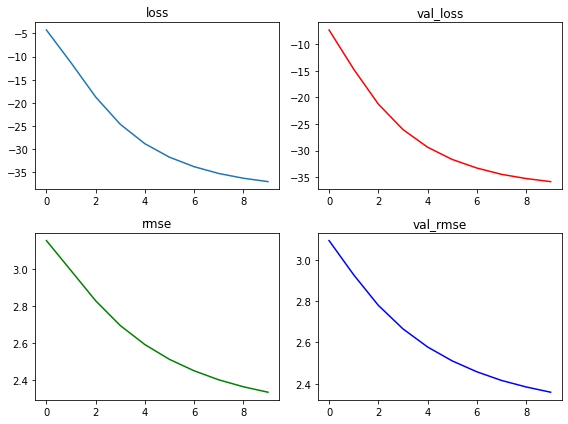

In [29]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

## 2.2 MLP  
  
신경망을 이용한 파트

$\hat{y_{ui}} = \sigma(h^T a(p_u * q_u + W [p_{u_{1,1}}\  q_{u_{2,1}}] + b))$

In [35]:
Embedding_size = 16

class MLP(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(32,activation='elu')
        self.Layer2 = layers.Dense(16,activation='elu')
        self.Layer3 = layers.Dense(8,activation='elu')
        self.Layer4 = layers.Dense(1,activation='elu')
        self.dropout = layers.Dropout(0.2) # 0.5 보다 0.2가 더 좋다

    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        #mat = user_vec * movie_vec
        mat = keras.layers.Concatenate()([user_vec, movie_vec])
        x = mat + user_bias + movie_bias

        x = self.dropout(self.Layer1(x))
        x = self.dropout(self.Layer2(x))
        x = self.dropout(self.Layer3(x))

        return self.Layer4(x)



test_model2 = MLP(num_users, num_movies, Embedding_size)
test_model2.compile(loss = keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(lr=0.001), metrics=['RootMeanSquaredError'])

In [36]:
history2 = test_model2.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
626/626 [==============================] - 4s 6ms/step - loss: -34.9382 - root_mean_squared_error: 1.7847 - val_loss: -38.8991 - val_root_mean_squared_error: 1.1523
Epoch 2/10
626/626 [==============================] - 3s 5ms/step - loss: -38.7146 - root_mean_squared_error: 1.6192 - val_loss: -38.8991 - val_root_mean_squared_error: 1.3741
Epoch 3/10
626/626 [==============================] - 3s 5ms/step - loss: -38.7484 - root_mean_squared_error: 2.8336 - val_loss: -38.8993 - val_root_mean_squared_error: 2.6314
Epoch 4/10
626/626 [==============================] - 3s 5ms/step - loss: -38.7492 - root_mean_squared_error: 3.0778 - val_loss: -38.8995 - val_root_mean_squared_error: 2.6897
Epoch 5/10
626/626 [==============================] - 3s 5ms/step - loss: -38.7543 - root_mean_squared_error: 3.1143 - val_loss: -38.8996 - val_root_mean_squared_error: 2.7201
Epoch 6/10
626/626 [==============================] - 3s 5ms/step - loss: -38.7501 - root_mean_squared_error: 3.1899 - v

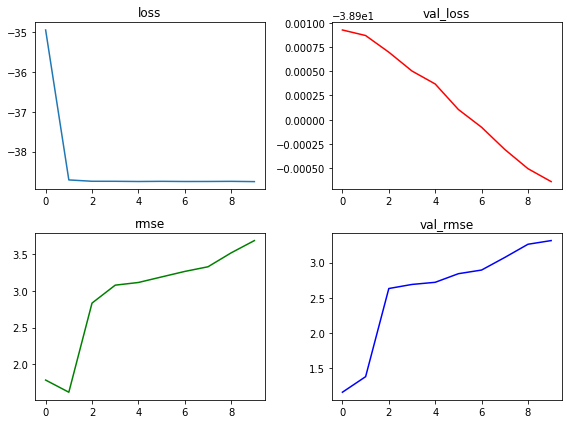

In [37]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history2.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history2.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history2.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history2.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

## 2.3 Neu-MF  
  
Concatenate GMF and MLP parts

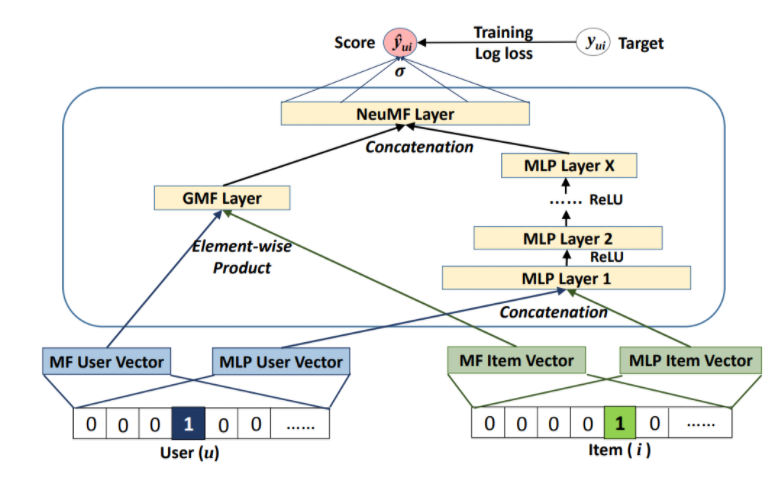

In [38]:
from IPython.display import Image
Image('/content/drive/My Drive/datasets/img/recommender/cnf.PNG')

In [43]:
Embedding_size = 16

class Neu_MF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(Neu_MF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(32,activation='elu')
        self.Layer2 = layers.Dense(16,activation='elu')
        self.Layer3 = layers.Dense(8,activation='elu')
        self.Layer4 = layers.Dense(1,activation='elu')
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs):
        
        # GMF

        user_vec_gmf = self.user_embedding(inputs[:,0])
        user_vec_gmf = Reshape(user_vec_gmf, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_gmf = self.user_bias(inputs[:,0])

        movie_vec_gmf = self.movie_embedding(inputs[:,1])
        movie_vec_gmf = Reshape(movie_vec_gmf, shape = (-1, self.embedding_size))
        movie_bias_gmf = self.movie_bias(inputs[:,1])

        mat_gmf = user_vec_gmf * movie_vec_gmf
        gmf = mat_gmf + user_bias_gmf + movie_bias_gmf

        # MLP

        user_vec_mlp = self.user_embedding(inputs[:,0])
        user_vec_mlp = Reshape(user_vec_mlp, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_mlp = self.user_bias(inputs[:,0])

        movie_vec_mlp = self.movie_embedding(inputs[:,1])
        movie_vec_mlp = Reshape(movie_vec_mlp, shape = (-1, self.embedding_size))
        movie_bias_mlp = self.movie_bias(inputs[:,1])

        # concat in MLP part

        concat_mlp = keras.layers.Concatenate()([user_vec_mlp, movie_vec_mlp])

        # MLP Layers
        x = self.dropout(self.Layer1(concat_mlp))
        x = self.dropout(self.Layer2(x))
        x = self.dropout(self.Layer3(x))
        mlp = x

        # concat MLP n GMF
        x = keras.layers.Concatenate(axis=-1)([gmf, mlp])

        # Final Prediction

        pred = self.Layer4(x)

        return pred

test_model3 = Neu_MF(num_users, num_movies, Embedding_size)
test_model3.compile(loss = keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(lr=0.001), metrics=['RootMeanSquaredError'])

In [44]:
history3 = test_model3.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
626/626 [==============================] - 4s 6ms/step - loss: -33.5150 - root_mean_squared_error: 1.8520 - val_loss: -38.8991 - val_root_mean_squared_error: 1.0991
Epoch 2/10
626/626 [==============================] - 4s 6ms/step - loss: -38.6826 - root_mean_squared_error: 1.4760 - val_loss: -38.8992 - val_root_mean_squared_error: 1.2357
Epoch 3/10
626/626 [==============================] - 4s 6ms/step - loss: -38.7299 - root_mean_squared_error: 1.6755 - val_loss: -38.8994 - val_root_mean_squared_error: 1.3894
Epoch 4/10
626/626 [==============================] - 4s 6ms/step - loss: -38.7440 - root_mean_squared_error: 1.8070 - val_loss: -38.8996 - val_root_mean_squared_error: 1.5650
Epoch 5/10
626/626 [==============================] - 4s 6ms/step - loss: -38.7495 - root_mean_squared_error: 2.0463 - val_loss: -38.8998 - val_root_mean_squared_error: 1.7946
Epoch 6/10
626/626 [==============================] - 4s 6ms/step - loss: -38.7523 - root_mean_squared_error: 2.2079 - v

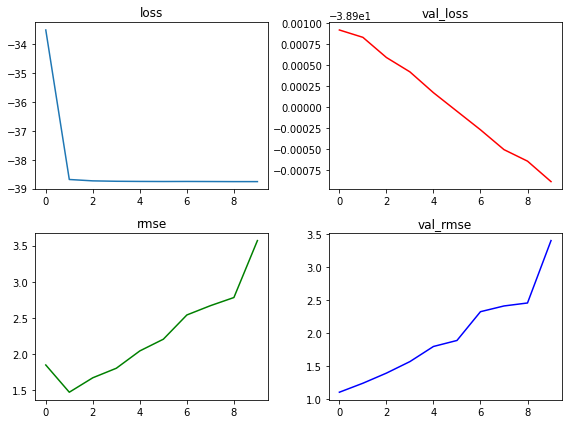

In [45]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history3.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history3.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history3.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history3.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

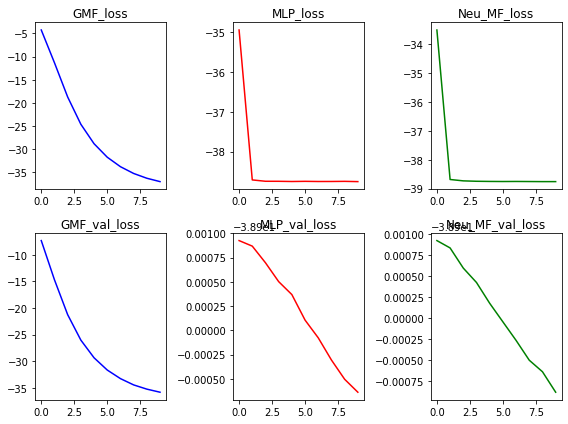

In [46]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(231) # instead of plt.subplot(2, 2, 1)
sub1.set_title('GMF_loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'],c='blue')

sub2 = fig.add_subplot(232) 
sub2.set_title('MLP_loss') 
sub2.plot(history2.history['loss'],c='red')

sub3 = fig.add_subplot(233) 
sub3.set_title('Neu_MF_loss') 
sub3.plot(history3.history['loss'],c='green')

sub4 = fig.add_subplot(234) 
sub4.set_title('GMF_val_loss') 
sub4.plot(history.history['val_loss'],c='blue')

sub5 = fig.add_subplot(235) 
sub5.set_title('MLP_val_loss') 
sub5.plot(history2.history['val_loss'],c='red')

sub6= fig.add_subplot(236) 
sub6.set_title('Neu_MF_val_loss') 
sub6.plot(history3.history['val_loss'],c='green')

plt.tight_layout()
plt.show()